# Deep Learning - Underwater object detection - PreProcessing notebook

This notebook is focused on the pre-processing step of the datasets.


In [2]:
# Import of used libraries

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from os.path import isfile, join, splitext
from os import listdir

In [3]:
# Google COLAB init
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  # copy dataset to local dir
  !mkdir -p ./datasets
  !cp /content/drive/MyDrive/Datasets/YOLO_UODD.zip ./datasets/YOLO_UODD.zip
  !cp /content/drive/MyDrive/Datasets/uodd.yaml ./uodd.yaml
  !unzip -q ./datasets/YOLO_UODD.zip -d ./datasets
  #!pip install ultralytics

## Part I - Image Pre-processing

The first pre-processing test will be with the Underwater Object Detection Dataset (UODD).

### Dataset composition

- **Training Set**: The largest subset of data used to train the model by adjusting its parameters. The model learns patterns and relationships from the training set to make predictions later on.

- **Validation Set**: Used to evaluate the model during training and select the best-performing model. The validation set helps fine-tune the model's parameters and avoid overfitting. It can also be used to compare the performance of different models and hyperparameter choices.

- **Test Set**: Used to evaluate the final model's performance on unseen data. The test set provides an unbiased approximation of the model's accuracy in the real world. It can also be used to evaluate competing models.

In [4]:
# Load the images
uodd_pic_path = 'Datasets/Underwater-object-detection-dataset/imgs/test'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(str(os.path.join(folder, filename)))
        if img is not None:
            images.append(img)
    return images

loaded_images = load_images_from_folder(uodd_pic_path)
print(f"[UODD] Loaded {len(loaded_images)} images.")

[UODD] Loaded 506 images.


In [5]:
# Enhance the image by improving its visibility using histogram equalization.
def enhance_image(image):
    # Convert to YUV color space
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # Equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # Convert back to BGR color space
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

# Reduce noise in the image using Gaussian Blur.
def reduce_noise(image):
    # Apply Gaussian Blur
    img_output = cv2.GaussianBlur(image, (5, 5), 0)
    return img_output

# Correct the color of the image using CLAHE (Contrast Limited Adaptive Histogram Equalization).
def correct_color(image):
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # Split the channels
    l, a, b = cv2.split(lab)
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    # Merge channels back
    lab = cv2.merge((l, a, b))
    # Convert back to BGR color space
    img_output = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return img_output

In [6]:
# Step 2 - Pre-process the images

def preprocess_image(image):
    # Apply enhancement
    enhanced_img = enhance_image(image)
    # Apply noise reduction
    noise_reduced_img = reduce_noise(enhanced_img)
    # Apply color correction
    corrected_img = correct_color(noise_reduced_img)
    return corrected_img

# Pre-process all images
preprocessed_images = [preprocess_image(img) for img in loaded_images]

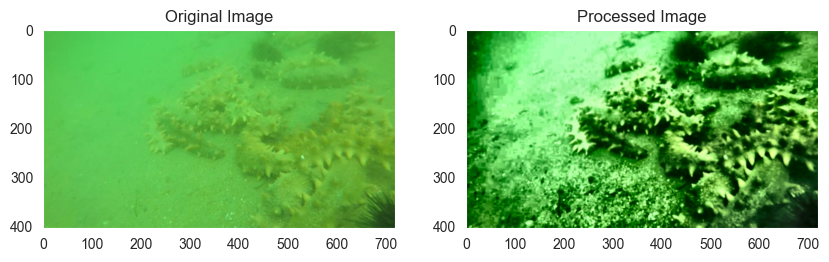

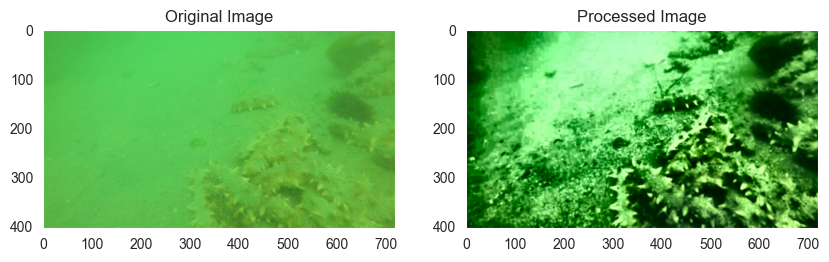

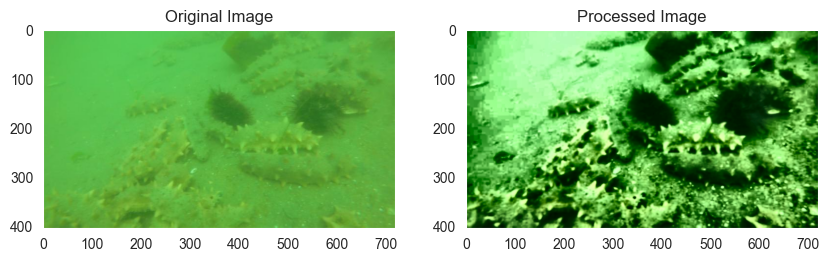

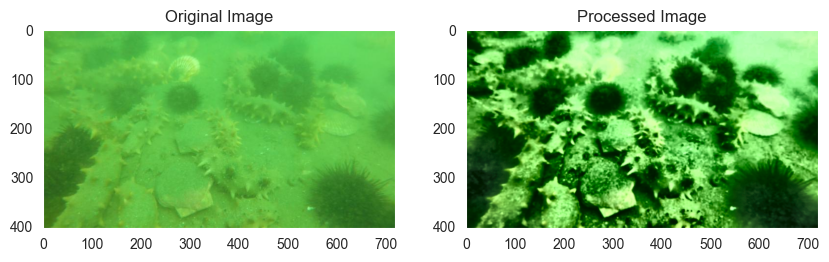

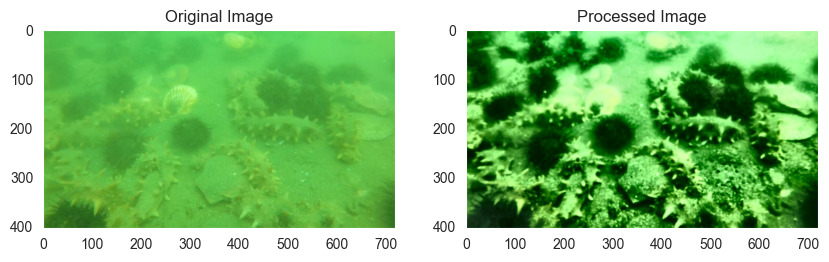

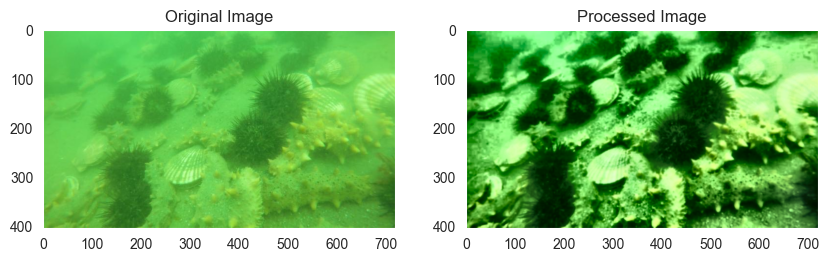

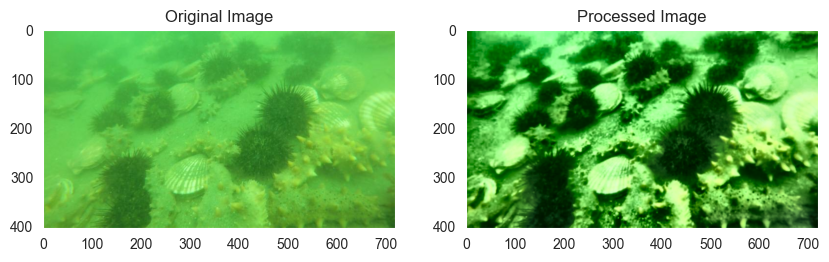

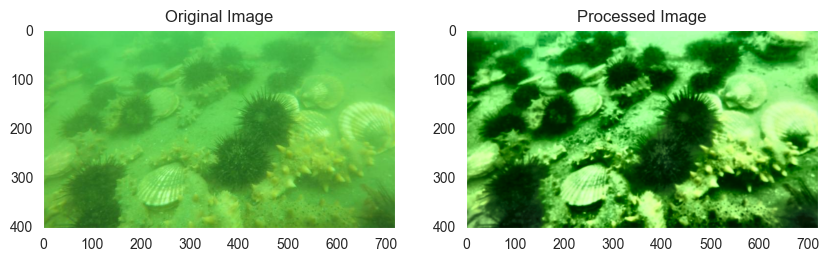

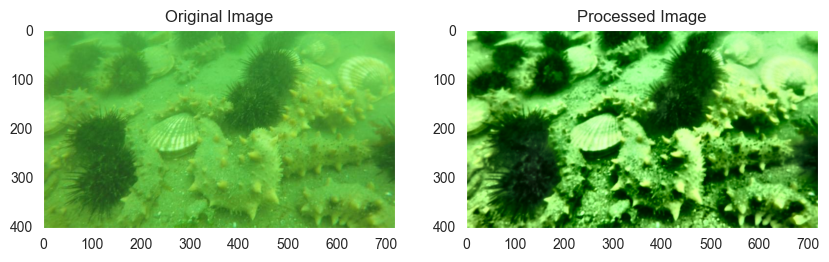

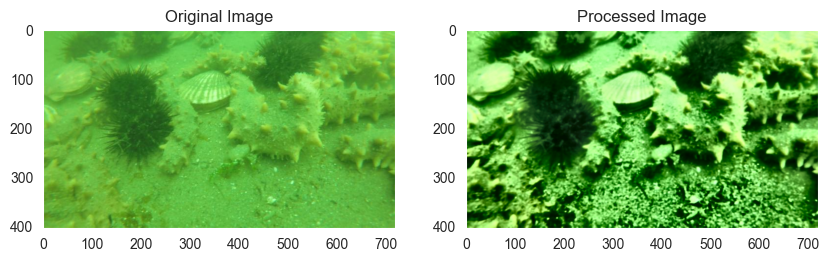

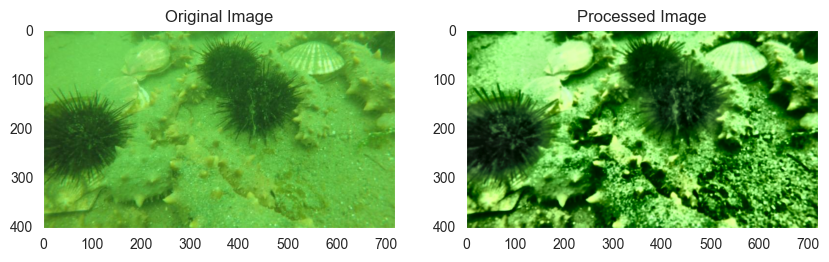

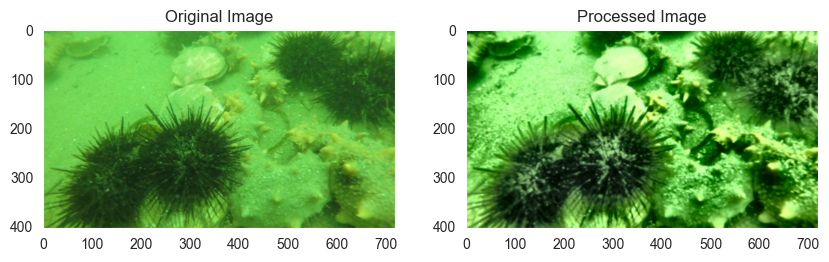

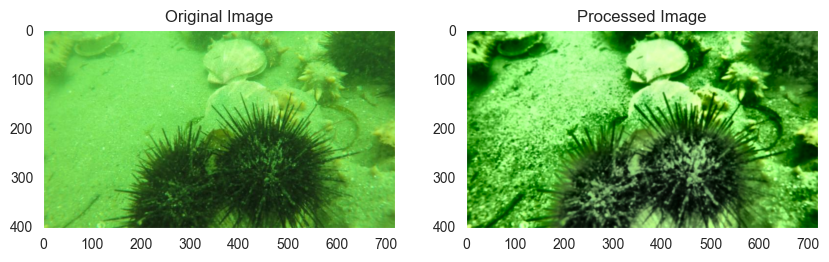

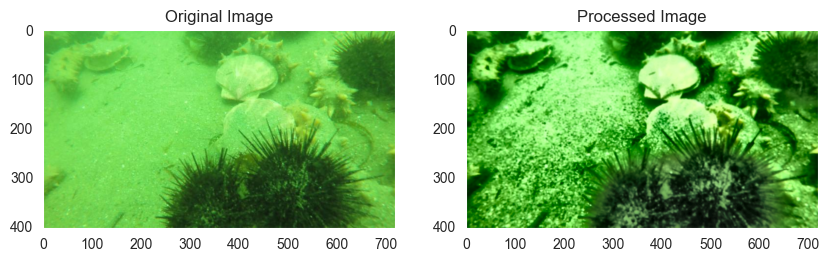

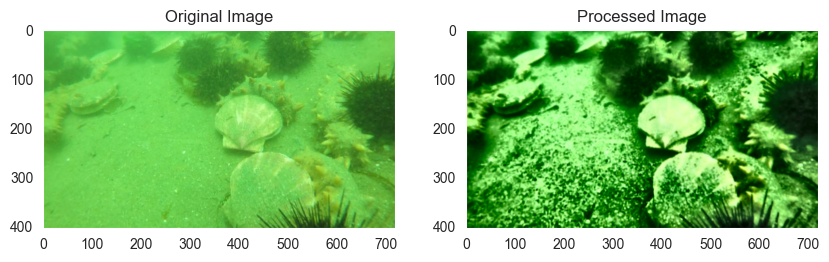

In [7]:
# Step 3 - Display the pre-processed images
def display_images(original, processed, index):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.grid(None)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.grid(None)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title('Processed Image')
    plt.show()

# Display the first 5 images for comparison
for i in range(15):
    display_images(loaded_images[i], preprocessed_images[i], i)

## Part II - Data preparation for the YOLO model

This part focuses on preparing the data YOLO model to detect objects in the UODD dataset.


In [7]:
# Constants for paths
DATASET_BASE_PATH = 'Datasets/Underwater-object-detection-dataset'
IMG_PATHS = {
    'train': join(DATASET_BASE_PATH, 'imgs/train'),
    'val': join(DATASET_BASE_PATH, 'imgs/val'),
    'test': join(DATASET_BASE_PATH, 'imgs/test')
}
LABEL_PATHS = {
    'train': join(DATASET_BASE_PATH, 'labels/train'),
    'val': join(DATASET_BASE_PATH, 'labels/val'),
    'test': join(DATASET_BASE_PATH, 'labels/test')
}
YOLO_BASE_PATH = './Datasets/YOLO_UODD'
YOLO_IMG_PATHS = {k: join(YOLO_BASE_PATH, f'images/{k}') for k in IMG_PATHS}
YOLO_LABEL_PATHS = {k: join(YOLO_BASE_PATH, f'labels/{k}') for k in LABEL_PATHS}

# Utility function to load and preprocess images from a folder
def load_and_preprocess_images(folder_path):
    return [preprocess_image(img) for img in load_images_from_folder(folder_path)]

# Utility function to get filenames without extension from a folder
def get_filenames_without_extension(folder_path):
    return [splitext(f)[0] for f in listdir(folder_path) if isfile(join(folder_path, f))]

# Ensure directories exist
for path in YOLO_IMG_PATHS.values():
    os.makedirs(path, exist_ok=True)
for path in YOLO_LABEL_PATHS.values():
    os.makedirs(path, exist_ok=True)

# Process dataset for a given set type (train/val/test)
def process_dataset(set_type):
    images = load_and_preprocess_images(IMG_PATHS[set_type])
    filenames = get_filenames_without_extension(IMG_PATHS[set_type])

    for i, img in enumerate(images):
        img_name = f'{filenames[i]}.jpg'
        cv2.imwrite(str(join(YOLO_IMG_PATHS[set_type], img_name)), img)
        shutil.copy(join(LABEL_PATHS[set_type], f'{filenames[i]}.txt'), YOLO_LABEL_PATHS[set_type])

# Preprocess and organize datasets
for set_type in ['train', 'val', 'test']:
    process_dataset(set_type)

In [9]:
# ZIP the YOLO dataset to export for COLAB
destination = './Datasets/YOLO_UODD_dataset'
shutil.make_archive(destination, 'zip', YOLO_BASE_PATH)

print(f"ZIP archive {destination}.zip created successfully.")

ZIP archive YOLO_UODD_dataset.zip created successfully.


In [ ]:
# ZIP the pre-processed dataset to export for COLAB
destination = './Datasets/Preprocessed_UODD_dataset'
